In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [45]:
COMMON_SURVEY_KEYS = {
    'es1': [
        'f_MIPS24',
        'f_MIPS70',
        'f_MIPS160',
        'f_PACS100',
        'f_PACS160',
        'f_SPIRE250',
        'f_SPIRE350',
        'f_SPIRE500',
        # 'mag_U_VOICE', # no U band for wcdfs
        'mag_G_DES',
        'mag_R_DES',
        'mag_I_DES',
        # 'mag_Z_DES', # drop
        # 'mag_Y_DES', # drop
        'mag_Z_VIDEO', #
        'mag_Y_VIDEO', #
        'mag_J_VIDEO', 
        'mag_H_VIDEO', 
        'mag_Ks_VIDEO', 
        'mag_CH1',
        'mag_CH2'
        ],
    'wcdfs': [
        'f_MIPS24',
        'f_MIPS70',
        'f_MIPS160',
        'f_PACS100',
        'f_PACS160',
        'f_SPIRE250',
        'f_SPIRE350',
        'f_SPIRE500',
        'mag_R_VOICE',
        'mag_G_HSC',
        'mag_I_HSC',
        'mag_Z_HSC',
        'mag_Y_VIDEO', 
        'mag_J_VIDEO', 
        'mag_H_VIDEO',  
        'mag_Ks_VIDEO', 
        'mag_CH1',
        'mag_CH2'
    ],
    'xmmlss': [
        'f_MIPS24',
        'f_MIPS70',
        'f_MIPS160',
        'f_PACS100',
        'f_PACS160',
        'f_SPIRE250',
        'f_SPIRE350',
        'f_SPIRE500',
        # 'mag_U_CFHT', # no U band for wcdfs
        'mag_G_HSC',
        'mag_R_HSC',
        'mag_I_HSC',
        'mag_Z_HSC', #
        'mag_Y_HSC', #
        # 'mag_Z_VIDEO', # drop
        # 'mag_Y_VIDEO', # drop
        'mag_J_VIDEO',
        'mag_H_VIDEO', 
        'mag_Ks_VIDEO', 
        'mag_CH1',
        'mag_CH2'
    ]
}

In [47]:
final_photometry = {
    'sorted_filters': ['G', 'R', 'I', 'Z', 'Y', 'J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500'],
    'data': None,  # to fill in
    'sorted_wavelengths': [365, 475, 620, 750, 880, 980, 1250, 1650, 2150, 3550, 4500, 24000, 70000, 100000, 160000, 250000, 350000, 500000],  # nm
    'data_err': None,  # to fill in
    'tractor_id': None  # to fill in
}

for field in ('es1', 'wcdfs', 'xmmlss'):
    with open(f'/Users/adamboesky/Research/ay98/preprocessing/clean_data/{field}_preprocessed.pkl', 'rb') as f:
        field_data = pickle.load(f)
        # Iterate through the fields of the photometry data and add to final field accordingly
        temp_data = None
        temp_err = None
        temp_tractor_ids = np.array(field_data['photometry']['tractor_id']).flatten()
        for filt, filt_data, filt_err, tractor_id in zip(field_data['photometry']['sorted_filters'], field_data['photometry']['data'].T, field_data['photometry']['data_err'].T, field_data['photometry']['tractor_id']):
            if filt in COMMON_SURVEY_KEYS[field]:  # make sure field is desired
                if temp_data is None:
                    print(f'Data {field} with shape {filt_data.shape}')
                    temp_data = np.atleast_2d(filt_data).T
                    temp_err = np.atleast_2d(filt_err).T
                else:
                    temp_data = np.hstack((temp_data, np.atleast_2d(filt_data).T))
                    temp_err = np.hstack((temp_err, np.atleast_2d(filt_err).T))
        
        if final_photometry['data'] is None:
            final_photometry['data'] = temp_data
            final_photometry['data_err'] = temp_err
            final_photometry['tractor_id'] = temp_tractor_ids
        else:
            final_photometry['data'] = np.vstack((final_photometry['data'], temp_data))
            final_photometry['data_err'] = np.vstack((final_photometry['data_err'], temp_err))
            final_photometry['tractor_id'] = np.concatenate((final_photometry['tractor_id'], temp_tractor_ids))

Data es1 with shape (762073,)
Data wcdfs with shape (745326,)
Data xmmlss with shape (1183643,)


In [48]:
with open(f'/Users/adamboesky/Research/ay98/preprocessing/clean_data/all_photometry.pkl', 'wb') as f:
    pickle.dump(final_photometry, f)

In [53]:
final_cat = {}

for field in ('es1', 'wcdfs', 'xmmlss'):
    with open(f'/Users/adamboesky/Research/ay98/preprocessing/clean_data/{field}_preprocessed.pkl', 'rb') as f:
        cat_data = pickle.load(f)

        # Iterate through the fields of the photometry data and add to final field accordingly
        temp_keys = None
        temp_err_keys = None
        temp_data = None
        temp_err = None
        temp_tractor_ids = np.array(field_data['photometry']['tractor_id']).flatten()
        for key, err_key, data, err_data in zip(cat_data['catalog']['keys'], cat_data['catalog']['err_keys'], cat_data['catalog']['data'].T, cat_data['catalog']['data_err'].T):
            if key in ['Mstar_best', 'SFR_best']:
                key = f'log_{key}'

            print(f'Data {field} with shape {data.shape}')
            if temp_data is None:
                temp_data = np.atleast_2d(data).T
                temp_err = np.atleast_2d(err_data).T
                temp_keys = [key]
                temp_err_keys = [err_key]
            else:
                temp_data = np.hstack((temp_data, np.atleast_2d(data).T))
                temp_err = np.hstack((temp_err, np.atleast_2d(err_data).T))
                temp_keys.append(key)
                temp_err_keys.append(err_key)

        if final_cat.get('data') is not None:
            final_cat['data'] = np.vstack((final_cat['data'], temp_data))
            final_cat['data_err'] = np.vstack((final_cat['data_err'], temp_err))
            final_cat['tractor_id'] = np.concatenate((final_cat['tractor_id'], temp_tractor_ids))
        else:
            final_cat['data'] = temp_data
            final_cat['data_err'] = temp_err
            final_cat['keys'] = temp_keys
            final_cat['err_keys'] = temp_err_keys
            final_cat['tractor_id'] = temp_tractor_ids

Data es1 with shape (762073,)
Data es1 with shape (762073,)
Data es1 with shape (762073,)
Data wcdfs with shape (745326,)
Data wcdfs with shape (745326,)
Data wcdfs with shape (745326,)
Data xmmlss with shape (1183643,)
Data xmmlss with shape (1183643,)
Data xmmlss with shape (1183643,)


In [54]:
with open(f'/Users/adamboesky/Research/ay98/preprocessing/clean_data/all_cat.pkl', 'wb') as f:
    pickle.dump(final_cat, f)

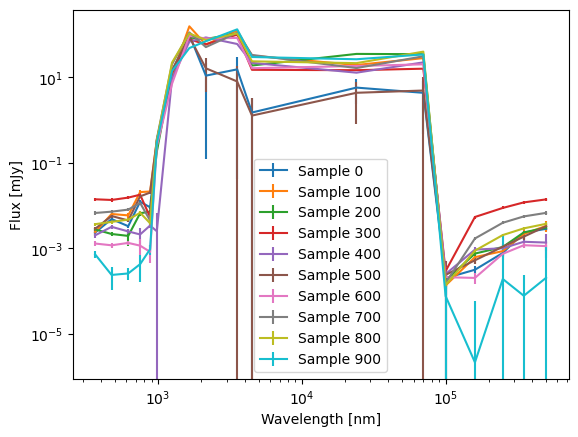

In [57]:
for sample in np.arange(0, 1000, 100):
    plt.errorbar(final_photometry['sorted_wavelengths'], final_photometry['data'][sample], yerr=final_photometry['data_err'][sample], label=f'Sample {sample}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux [mJy]')
plt.legend()
plt.show()

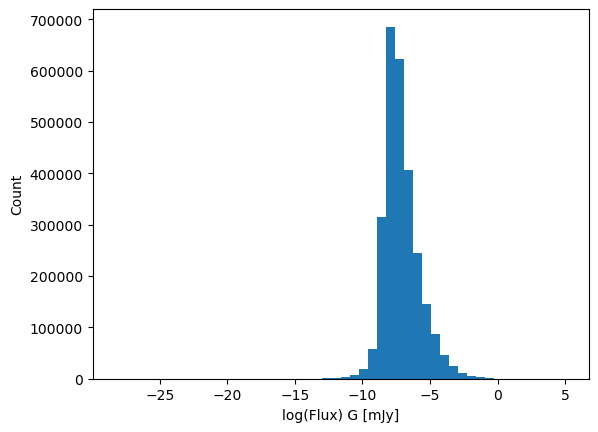

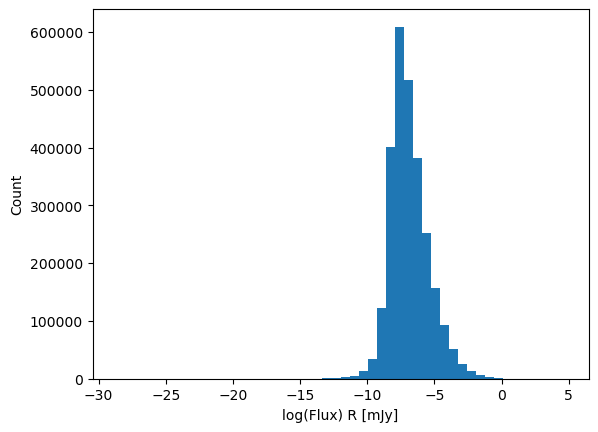

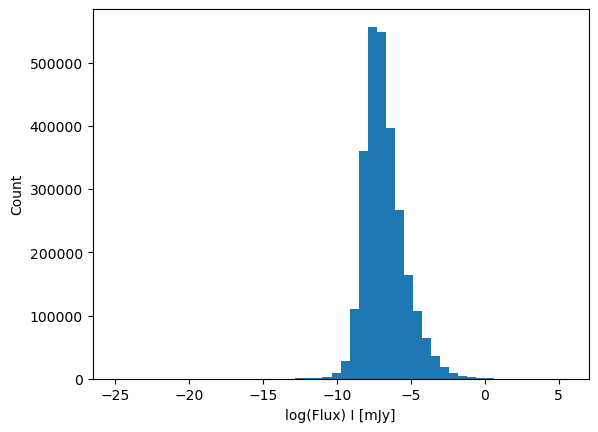

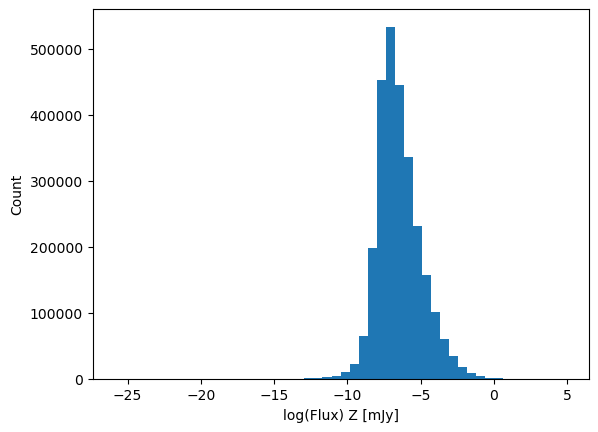

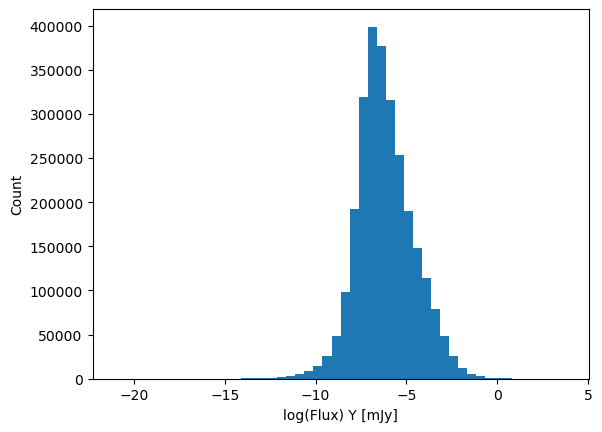

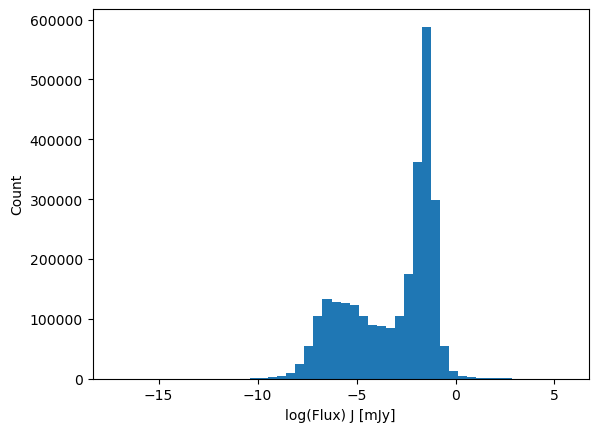

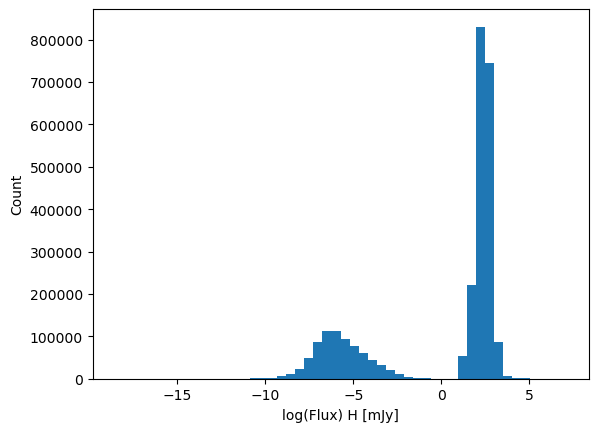

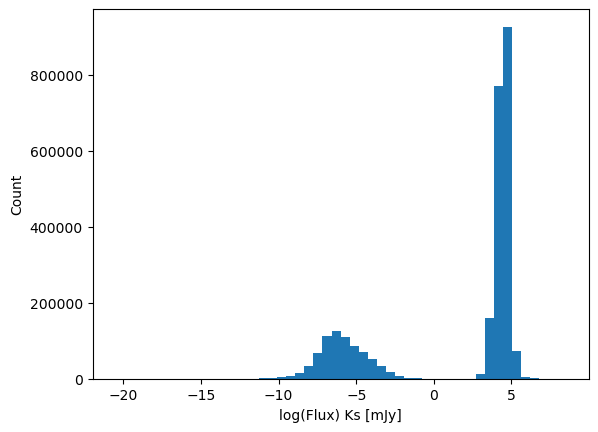

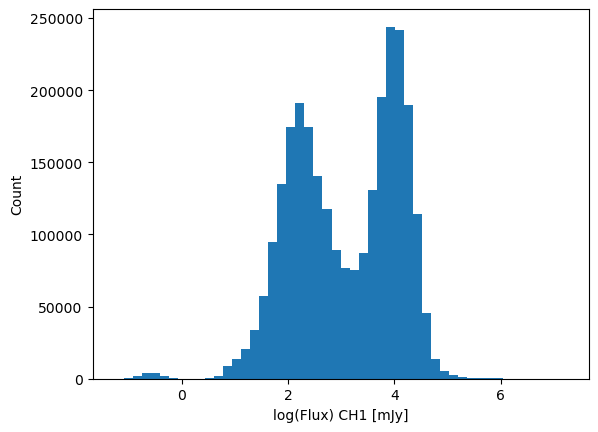

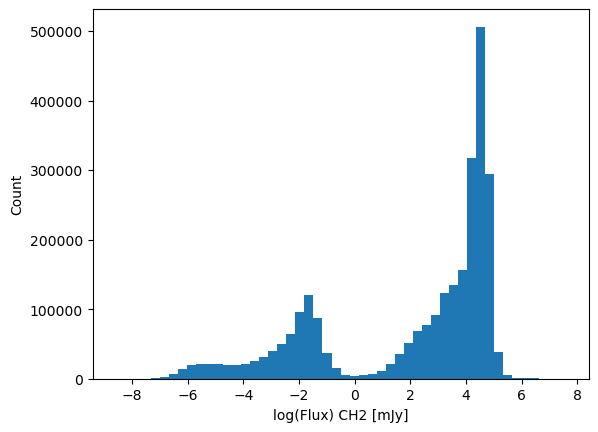

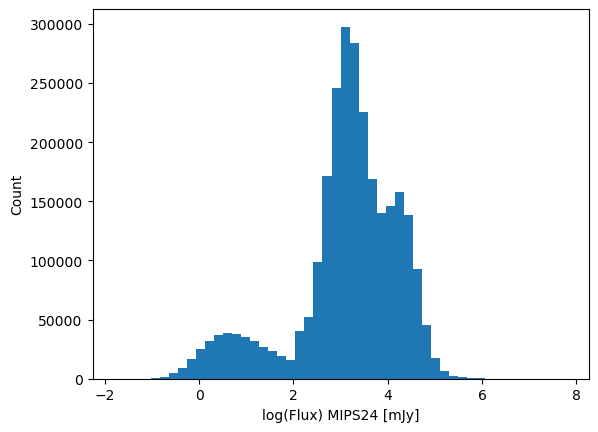

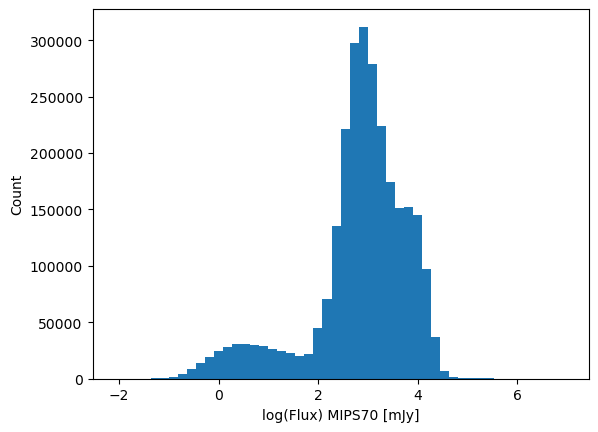

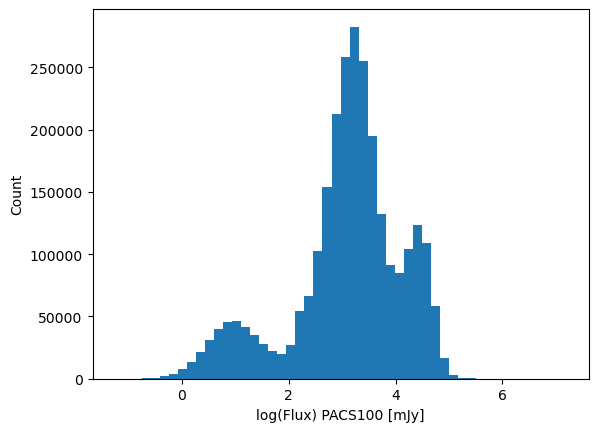

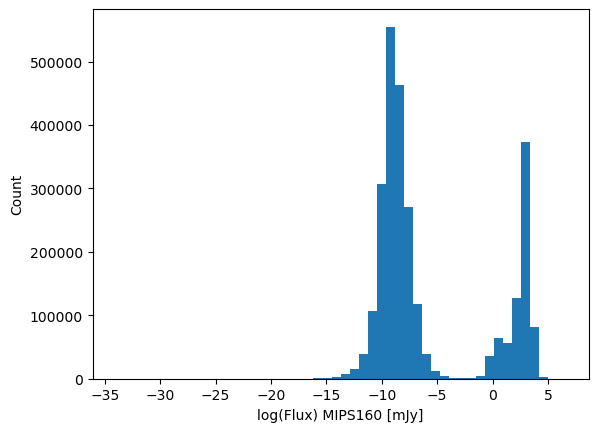

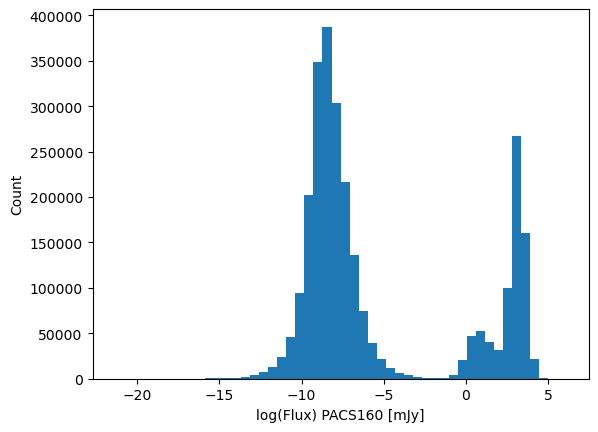

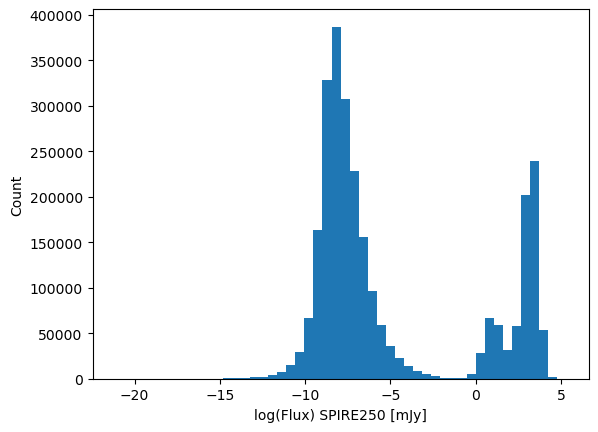

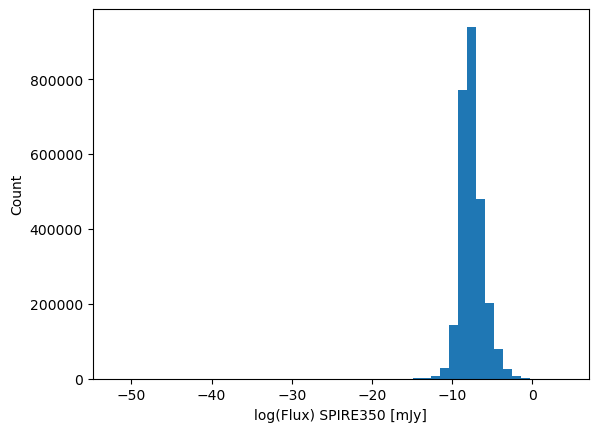

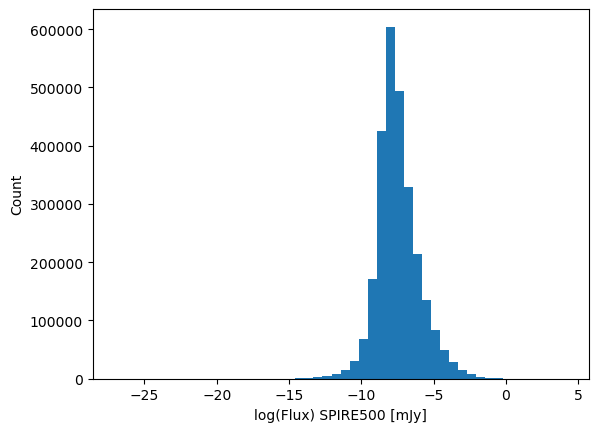

In [61]:
# Filter histograms
for filter, vals in zip(final_photometry['sorted_filters'], final_photometry['data'].T):
    plt.figure()
    plt.hist(np.log(vals), bins=50)
    plt.xlabel(f'log(Flux) {filter} [mJy]')
    plt.ylabel('Count')
    plt.show()

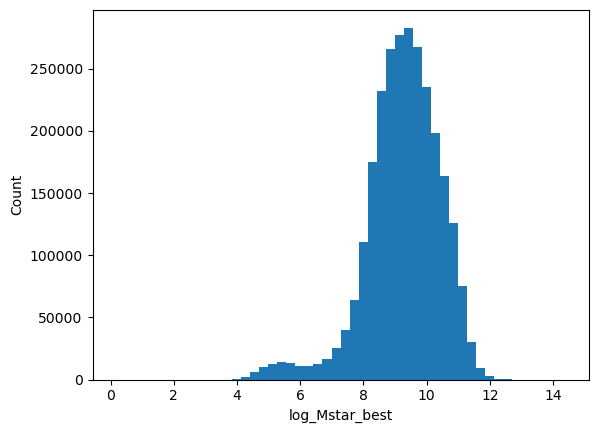

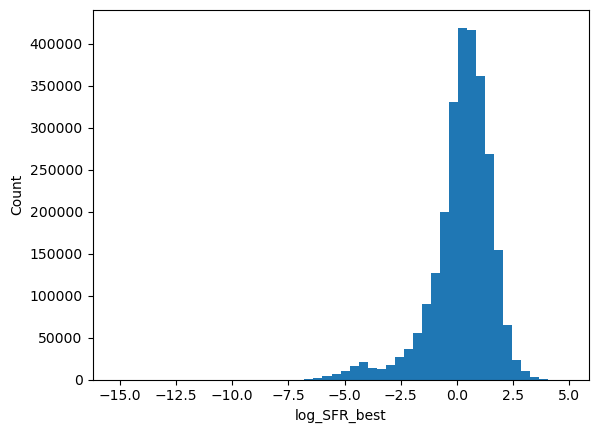

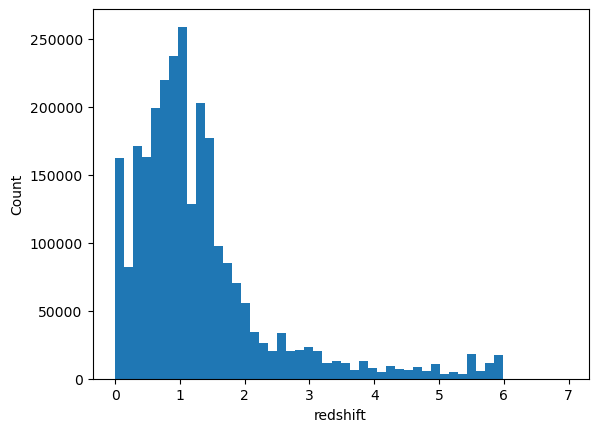

In [62]:
for out_k, vals in zip(final_cat['keys'], final_cat['data'].T):
    plt.figure()
    plt.hist(vals, bins=50)
    plt.ylabel('Count')
    plt.xlabel(out_k)
    plt.show()

In [16]:
from astropy.io import fits
fits_data = np.array(fits.open('/Volumes/T7/ay_98_data/Zou_data/sed_catalog/es1.v1.fits')[1].data)
fits_data = np.hstack((fits_data, fits.open('/Volumes/T7/ay_98_data/Zou_data/sed_catalog/wcdfs.v1.fits')[1].data))
fits_data = np.hstack((fits_data, fits.open('/Volumes/T7/ay_98_data/Zou_data/sed_catalog/xmmlss.v1.fits')[1].data))

In [17]:
print(fits_data['ztype'])
print(np.unique(fits_data['ztype']))
print('# of zphot: \t', np.sum(fits_data['ztype'] == b'zphot'))
print('# of zspec: \t', np.sum(fits_data['ztype'] == b'zspec'))

[b'zphot' b'zphot' b'nan' ... b'zphot' b'zphot' b'zphot']
[b'nan' b'zphot' b'zspec']
# of zphot: 	 2733754
# of zspec: 	 99037


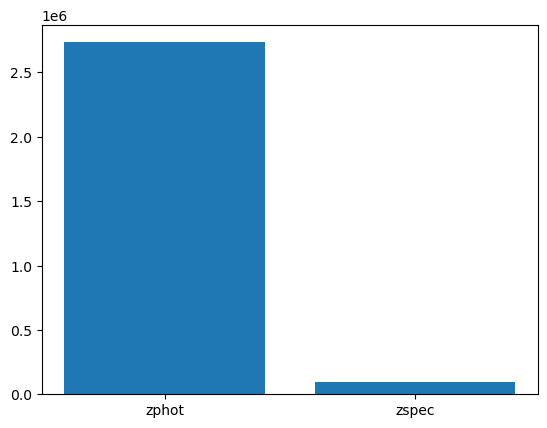

In [28]:
plt.bar(['zphot', 'zspec'], [np.sum(fits_data['ztype'] == b'zphot'), np.sum(fits_data['ztype'] == b'zspec')])
plt.show()

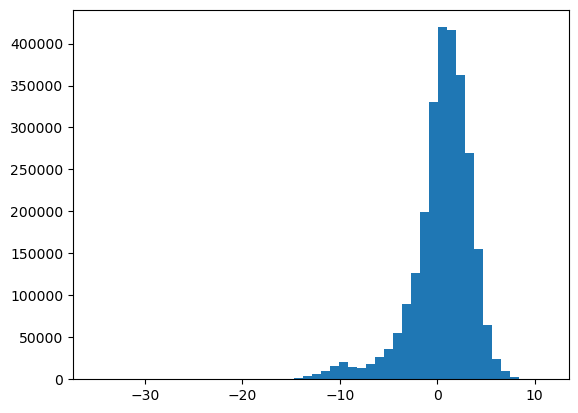

In [29]:
plt.hist(np.log(fits_data['SFR_best']), bins=50)
plt.show()

In [25]:
with open(f'/Users/adamboesky/Research/ay98/preprocessing/clean_data/all_cat.pkl', 'rb') as f:
        all_cat = pickle.load(f)
cat = all_cat['data']
cat_err = all_cat['data_err']

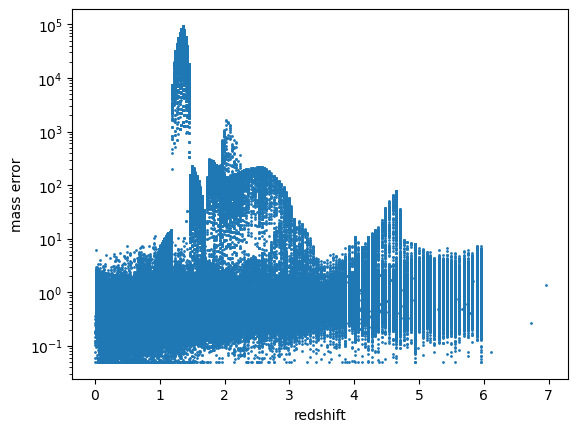

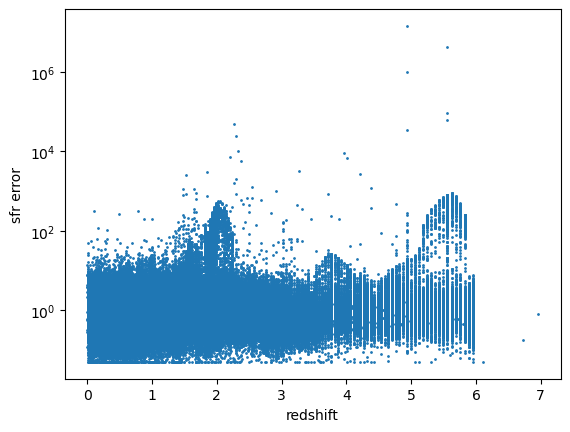

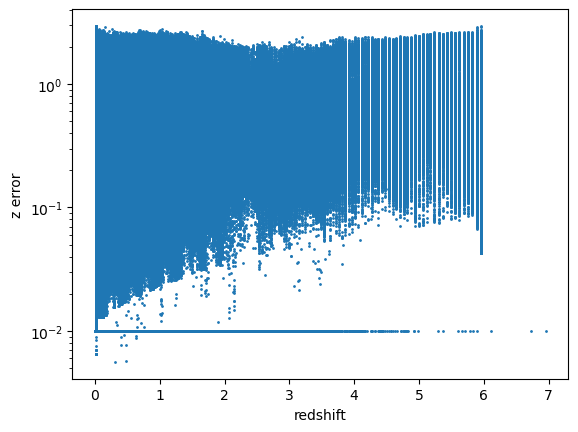

In [26]:
for ind, field in enumerate(('mass', 'sfr', 'z')):
    plt.figure()
    plt.scatter(cat[:, 2], cat_err.T[ind], s=1)
    plt.xlabel('redshift')
    plt.ylabel(f'{field} error')
    plt.yscale('log')
    plt.show()

Save a file to lookup coordinates for a given tractor ID

In [95]:
coord_lookup_table = fits_data['Tractor_ID']
coord_lookup_table = np.vstack((coord_lookup_table, fits_data['RA']))
coord_lookup_table = np.vstack((coord_lookup_table, fits_data['DEC']))
coord_lookup_table = coord_lookup_table.T

# Convert columns to appropriate types and form the structured array
dtypes = [('tractor_id', 'S32'), ('RA', 'f8'), ('DEC', 'f8')]
coord_lookup_table = np.array(list(zip(coord_lookup_table[:, 0], coord_lookup_table[:, 1].astype(float), coord_lookup_table[:, 2].astype(float))), dtype=dtypes)

with open('/Users/adamboesky/Research/ay98/preprocessing/clean_data/coord_lookup_table.pkl', 'wb') as f:
    pickle.dump(coord_lookup_table, f)

In [96]:
coord_lookup_table[0]

(b'644246851693', 9.71018059, -44.03439074)

In [120]:
from typing import Tuple
def get_coords_for_id(tractor_id: np.bytes_, lookup_table_path: str = '/Users/adamboesky/Research/ay98/preprocessing/clean_data/coord_lookup_table.pkl') -> Tuple[float, float]:
    """Function used to get the coordinates of a given tractor ID."""
    with open(lookup_table_path, 'rb') as f:
        coord_lookup_table = pickle.load(f)
    return coord_lookup_table[coord_lookup_table['tractor_id'] == tractor_id][0][1], coord_lookup_table[coord_lookup_table['tractor_id'] == tractor_id][0][2]

Galaxy with tractor id=b'644246429973' which has coordinates (9.170842439066458, -45.14925545303415)


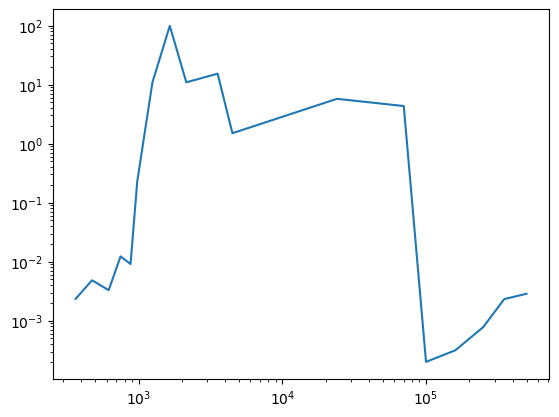

In [121]:
t_id = final_photometry['tractor_id'][0]
print(f"Galaxy with tractor id={t_id} which has coordinates {get_coords_for_id(t_id)}")
plt.plot(final_photometry['sorted_wavelengths'], final_photometry['data'][0])
plt.xscale('log')
plt.yscale('log')

Galaxy with tractor id=b'644246429998' which has coordinates (8.678235333001934, -45.14593829434927)


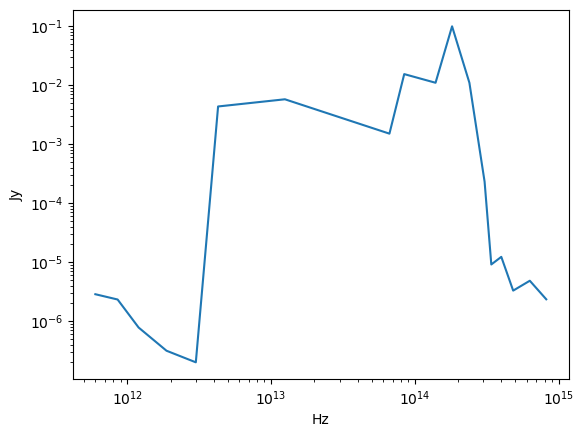

In [132]:
t_id = final_photometry['tractor_id'][22]
print(f"Galaxy with tractor id={t_id} which has coordinates {get_coords_for_id(t_id)}")
plt.plot( 2.998E17 / np.array(final_photometry['sorted_wavelengths']), final_photometry['data'][0]/1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hz')
plt.ylabel('Jy')
plt.show()

Galaxy with tractor id=b'644246431133' which has coordinates (9.940671216027761, -45.13994294500937)


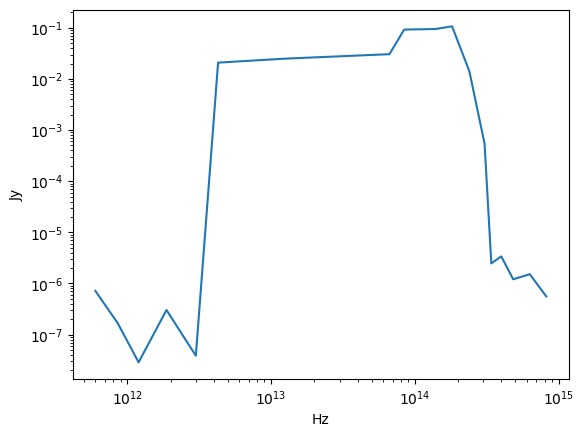

: 

In [137]:
indx = 999
t_id = final_photometry['tractor_id'][indx]
print(f"Galaxy with tractor id={t_id} which has coordinates {get_coords_for_id(t_id)}")
plt.plot(2.998E17 / np.array(final_photometry['sorted_wavelengths']), final_photometry['data'][indx]/1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hz')
plt.ylabel('Jy')
plt.show()